In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Function to invert colors (black to white and vice versa)
def invert_colors(image):
    return 255 - image

#  data augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=0.03,
    width_shift_range=3,
    height_shift_range=3,
    rotation_range=2,
    preprocessing_function=invert_colors,  # Apply color inversion
    rescale=1./255,
    validation_split=0.20  # Split the data into training and validation sets
)

# path to dataset
dataset_path = '/kaggle/input/data'

# image size
img_size = (64,64)


# data generator for training data
train_datagen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='rgb',  
    class_mode='categorical', 
    batch_size=32,
    subset='training'
)

#  data generator for validation data
valid_datagen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)


Found 6304 images belonging to 344 classes.
Found 1576 images belonging to 344 classes.


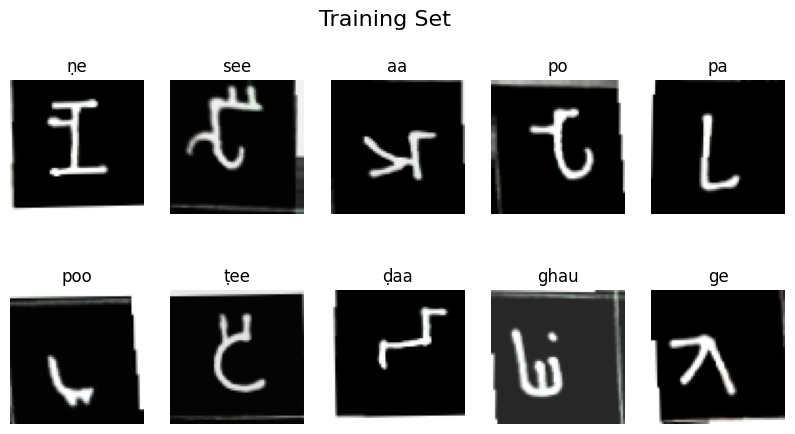

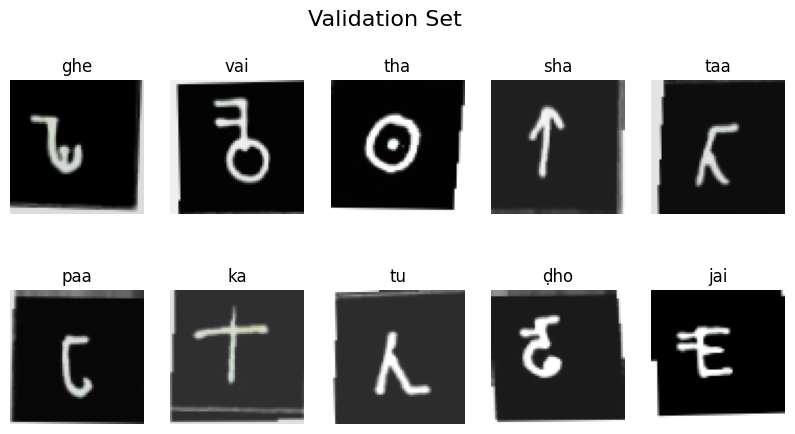

In [3]:
# Get class labels
class_labels = list(train_datagen.class_indices.keys())

# Plot images from the training set
plt.figure(figsize=(10, 5))
plt.suptitle('Training Set', fontsize=16)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Get a batch of images and labels
    batch = train_datagen.next()
    image = batch[0][i]  # Get the ith image from the batch
    label_index = np.argmax(batch[1][i])  # Get the index of the label in one-hot encoding
    
    # Display the image
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    
    # Display the pronunciation above the image
    plt.title(class_labels[label_index])

# Plot images from the validation set
plt.figure(figsize=(10, 5))
plt.suptitle('Validation Set', fontsize=16)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Get a batch of images and labels from the validation set
    batch = valid_datagen.next()
    image = batch[0][i]
    label_index = np.argmax(batch[1][i])
    
    # Display the image
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    
    # Display the pronunciation above the image
    plt.title(class_labels[label_index])

plt.show()


In [4]:
# Print image size of training images
train_batch = next(train_datagen)
print(f"Training Image Batch Shape: {train_batch[0].shape[1:]}")  # Exclude batch size

# Assuming valid_datagen is your validation data generator
# Print image size of validation images
valid_batch = next(valid_datagen)
print(f"Validation Image Batch Shape: {valid_batch[0].shape[1:]}")  # Exclude batch size


Training Image Batch Shape: (64, 64, 3)
Validation Image Batch Shape: (64, 64, 3)


In [5]:
num_classes = 344

In [6]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_datagen.classes), y=train_datagen.classes)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [8]:
# Set up distributed training on two GPUs
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    
    model = models.Sequential([
        
        # Convolutional layers
        layers.Conv2D(64, (3, 3), input_shape=(64, 64, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the output for Dense layers
        layers.Flatten(),

        # Dense layers
        layers.Dense(1024),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.7),

        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(344, activation='softmax')
    ])
    
    
    # Function to adjust learning rate during training
    def lr_scheduler(epoch, lr):
        if epoch % 5 == 0 and epoch > 0:
            lr = lr * 0.8  # Reduce learning rate by 20% every 5 epochs
        return lr
    
    # Define the learning rate scheduler
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

    #

    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(),
        metrics=['categorical_accuracy']
    )

    # Print the model summary
    model.summary()
    
    # Learning rate scheduler callback
    lr_schedule = LearningRateScheduler(lr_scheduler)

    # Train the model
    epochs = 80  # Adjust as needed
    history = model.fit(
        train_datagen,
        epochs=epochs,
        validation_data=valid_datagen,
        #class_weight=class_weight_dict,
        callbacks=[
            #ModelCheckpoint('best_model.h5', save_best_only=True),
            #EarlyStopping(patience=3, restore_best_weights=True),
            lr_schedule,
            #reduce_lr
        ]
    )


Number of devices: 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 62, 62, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None,

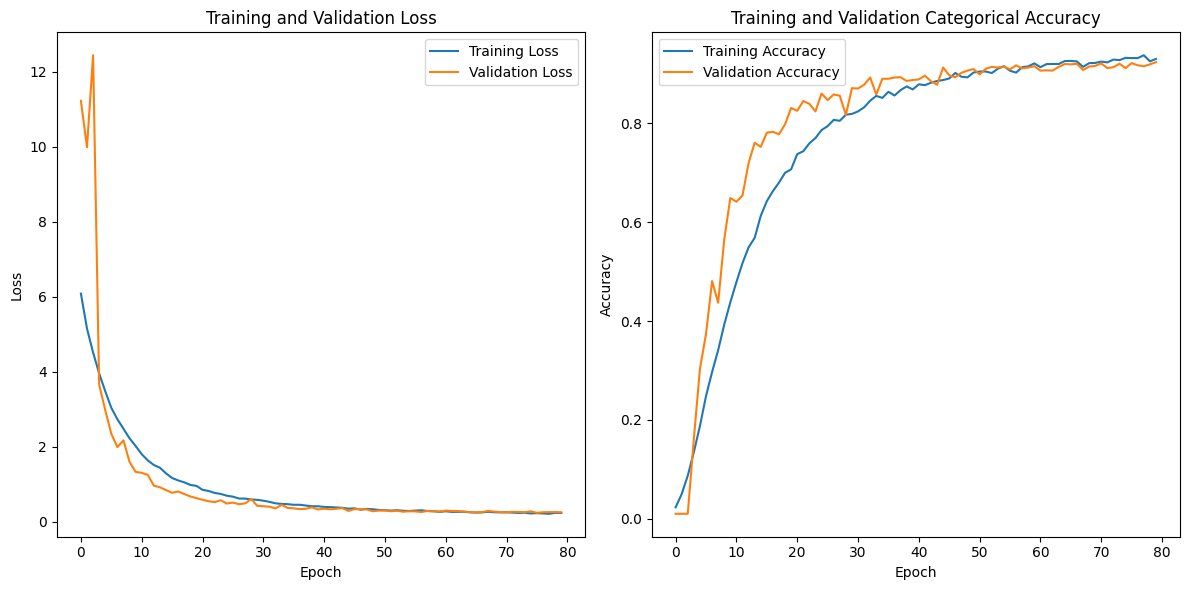

In [9]:

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation categorical accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Categorical Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(valid_datagen)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


50/50 [==============================] - 6s 121ms/step - loss: 0.2354 - categorical_accuracy: 0.9245
Test Loss: 0.2354
Test Accuracy: 0.9245


1/1 [==============================] - 0s 463ms/step


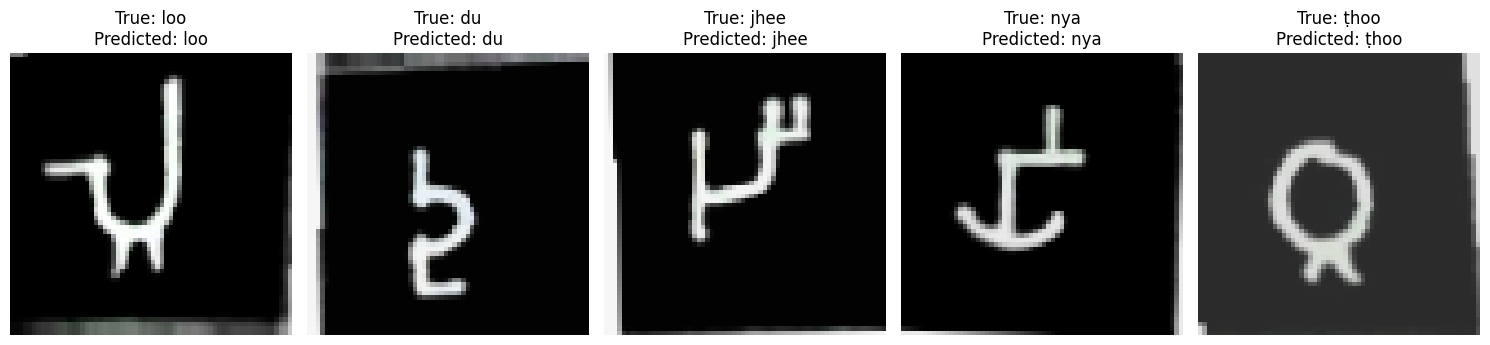

In [11]:
import numpy as np
import matplotlib.pyplot as plt


# Get predictions on the first 5 samples
x, y = valid_datagen[0]
predictions = model.predict(x)

# Get class names
class_names = list(valid_datagen.class_indices.keys())

# Plot images, true labels, and predicted labels
plt.figure(figsize=(15, 8))
for i in range(5):
    # Get true and predicted labels
    true_label = class_names[np.argmax(y[i])]
    predicted_label = class_names[np.argmax(predictions[i])]

    # Plot the image
    plt.subplot(2, 5, i + 1)

    # Ensure that the image is in the correct format (e.g., channels-last)
    image = np.squeeze(x[i])  # Squeeze removes any singleton dimensions
    plt.imshow(image, cmap='gray')  # Adjust cmap based on your image color format

    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 120ms/step


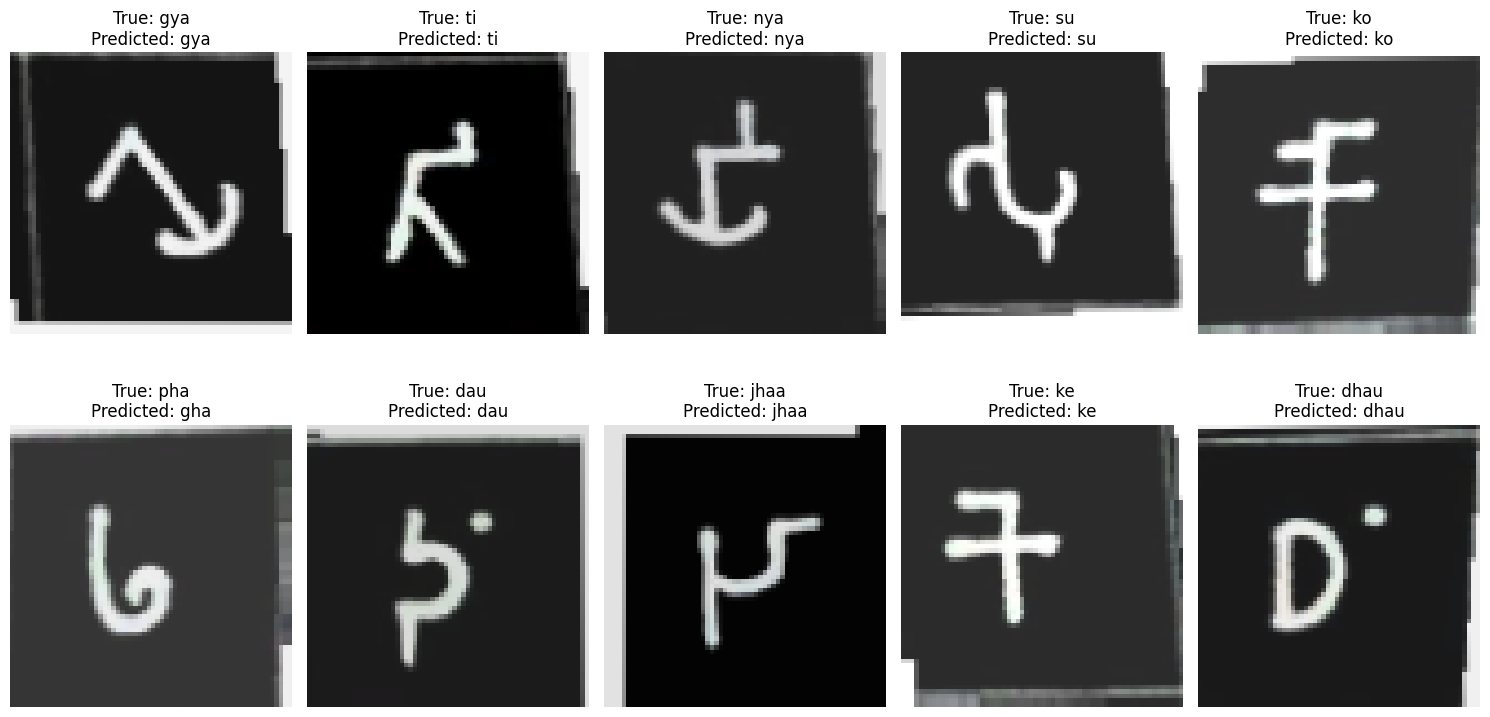

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Get the total number of batches and batch size in the validation set
total_batches = len(valid_datagen)
batch_size = valid_datagen.batch_size

# Define the number of samples you want to display
num_samples = min(10, total_batches * batch_size)

# Create a subplot for each selected sample
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    # Randomly choose a batch and an index within that batch
    batch_index = np.random.randint(total_batches)
    batch_data = valid_datagen[batch_index]

    # Get image and true label
    x, y = batch_data

    # Randomly choose an index within the batch
    index_within_batch = np.random.randint(batch_size)

    # Expand dimensions if needed (e.g., for grayscale images)
    x = np.squeeze(x[index_within_batch])

    # Get true and predicted labels
    true_label = class_names[np.argmax(y[index_within_batch])]
    predictions = model.predict(np.expand_dims(x, axis=0))  # Ensure correct shape for prediction
    predicted_label = class_names[np.argmax(predictions)]

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(x, cmap='gray')  # Adjust cmap based on your image color format
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
